In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

import scipy
import scipy.linalg as sla
from matplotlib import cm


import warnings
warnings.simplefilter("ignore", UserWarning)


def bhz(L, W, H, system_type):
    """A cuboid region of BHZ material with two leads attached.
    
    parameters for leads and scattering region can be defined separately
    """
    # Onsite and hoppings matrices used for building BHZ model
    def onsite(site, p):
        return (p.C + 2 * p.D1 + 4 * p.D2) * pauli.s0s0 + (p.M + 2 * p.B1 + 4 * p.B2) * pauli.s0sz

    def hopx(site1, site2, p):
        return - p.D2 * pauli.s0s0 - p.B2 * pauli.s0sz + p.A2 * 0.5j * pauli.sxsx

    def hopy(site1, site2, p):
        return - p.D2 * pauli.s0s0 - p.B2 * pauli.s0sz + p.A2 * 0.5j * pauli.sysx

    def hopz(site1, site2, p):
        return - p.D1 * pauli.s0s0 - p.B1 * pauli.s0sz + p.A1 * 0.5j * pauli.szsx

    def shape_lead(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W)

    def shape_sys(pos):
        (x, y, z) = pos
        return (0 <= z < H) and (0 <= y < W) and (0 <= x < L)

    def hopx_phase(site1, site2, p):
        x1, y1, z1 = site1.pos
        x2, y2, z2 = site2.pos
        return hopx(site1, site2, p) * np.exp(-0.5j * p.Bz * (x1 - x2) * (y1 + y2))
    
    lat = kwant.lattice.general(np.identity(3))    
    
    if system_type == 'sys':
        sys = kwant.Builder()
        sys[lat.shape(shape_sys, (0,0,0))] = lambda site, p: onsite(site, p) - p.mu_scat * np.eye(4)
    elif system_type == 'lead':
        sym = kwant.TranslationalSymmetry((1, 0, 0))
        sys = kwant.Builder(sym)
        sys[lat.shape(shape_lead, (0,0,0))] = lambda site, p: onsite(site, p) - p.mu_lead * np.eye(4)
    elif system_type == 'infinite':
        sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs)) 
        sys[lat.shape(lambda pos: True, (0, 0))] = lambda site, p: onsite(site, p) - p.mu_lead * np.eye(4)

    sys[kwant.HoppingKind((1,0,0), lat)] = hopx_phase
    sys[kwant.HoppingKind((0,1,0), lat)] = hopy
    sys[kwant.HoppingKind((0,0,1), lat)] = hopz
    return sys


def bhz_scatter(L, W, H):
    sys = bhz(L, W, H, 'sys')
    lead = bhz(L, W, H, 'lead')
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys


def cond_mu(p, L, W, H):
    p.mu_lead = 0.7
    sys = bhz_scatter(L, W, H)
    sys_leads_fixed = sys.finalized().precalculate(energy=0, args=[p])
    mus = np.linspace(-0.4, 0.4, 40)
    cond = [kwant.smatrix(sys_leads_fixed, energy=0, args=[p.update(mu_scat=mu)]).transmission(1, 0)
            for mu in mus]
    return np.array(cond), mus


def plot_cond_mu(cond, mus):
    kwargs = {'kdims': [r'$\mu$', r'$G\,[e^2/h]$']}
    plot = holoviews.Path((mus, cond), **kwargs)(plot={'xticks': 3, 'yticks': [0, 2, 4, 6, 8]},
                                                                style={'color': 'r'})
    return plot[-0.4:0.4, 0:8].relabel('Conductance')


def plot_bands(p, L, W, H):
    lead = bhz(L, W, H, 'lead')
    kwargs = {'k_x': np.linspace(-np.pi/3, np.pi/3, 101),
              'ylims': [-1, 1],
              'yticks': 5,
              'xticks': [(-np.pi/3, r'$-\pi/3$'), (0, r'$0$'), (np.pi/3, r'$\pi/3$')]}
    p.mu_lead = 0
    return spectrum(lead, p, **kwargs)


def plot_cond_spect(mu, cond_plot, bands_plot):
    return (cond_plot*holoviews.VLine(mu)(style={'color': 'b'}) + 
            bands_plot.relabel('Spectrum')*holoviews.HLine(mu)(style={'color': 'b'}))


def plot_warping(A=1.2, B=1.8, C=1.5, Kmax=1.0):
    
    def evaluate_on_grid(X, Y, func):
        """ X, Y should be in np.meshgrid form. It's enough for func to work on floats. """
        data = []
        for xx, yy in zip(X, Y):
            data.append([func(i,j) for i, j in zip(xx, yy)])
        data = np.array(data)
        return data

    def get_energy_function(A, B, C):
        """ Used for plotting of hexagonal warping. """
        def func(kx, ky):
            matrix = (A*(kx**2+ky**2)*pauli.s0 + B*(kx * pauli.sy - ky * pauli.sx) +
                      C* 0.5 * ( (kx+1j*ky)**3 + (kx-1j*ky)**3 ) * pauli.sz)
            return sla.eigh(matrix)[0]
        return func
    
    zmin, zmax = -1.0, 3.5
    xylims = (-1.2, 1.2)
    zlims = (-1.0, 3.5)
    kdims = [r'$k_x$', r'$k_y$']
    vdims = [r'E']
    # Generate a circular mesh
    N = 100
    r = np.linspace(0, Kmax, N)
    p = np.linspace(0, 2*np.pi, N)
    r, p = np.meshgrid(r, p)
    x, y = r*np.cos(p), r*np.sin(p)
    energies = evaluate_on_grid(x, y, func=get_energy_function(A, B, C))

    xy_ticks = [-1.2, 0, 1.2]
    zticks = [-1.0, 0.0, 1.0, 2.0, 3.0]
    style = {'xticks': xy_ticks, 'yticks': xy_ticks, 'zticks': zticks}
    kwargs = {'extents': (xylims[0], xylims[0], zlims[0], xylims[1], xylims[1], zlims[1]),
              'kdims': kdims,
              'vdims': vdims}
    %opts Trisurface (cmap='hsv' linewidth=0)
    plot = holoviews.Overlay([holoviews.Trisurface((x.flat, y.flat, energies[:, :, i].flat), **kwargs)(plot=style)
                              for i in range(energies.shape[-1])])
    return plot(plot={'Overlay': {'fig_size': 350}})

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

### Plan

* Spectroscopy of 3D TI
* Landau levels
* QPI
* The issue of bulk conductivity
* Hexagonal warping

# Introduction: searching the periodic table for topological materials

How do we find a topological insulator? In the first video of today, David Vanderbilt from Rutgers University will tell us more about the material science aspects of topological insulators research.

This is an expertise that no one from the course team has, so pay close attention to it: this material stands apart from the rest.

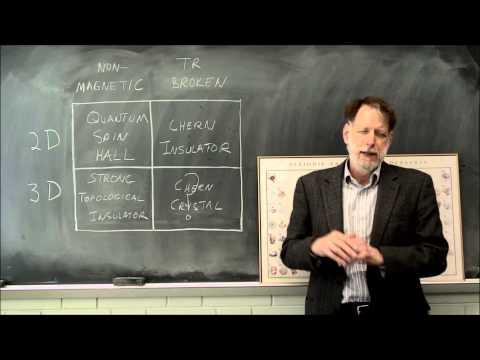

In [2]:
MoocVideo("62ZObitJ4DM",  src_location="6.2-intro")

In the rest of the lecture, we will instead discuss the experimental signatures of 3D topological insulators, similarly to what we did in the previous week for their 2D counterparts.

All the figures showing the experimental data are copyright of the Zahid Hasan lab, Princeton, 2015. They are available under CC-BY-NC-SA 4.0 International license.

# Conductance of a 3D topological insulator

Both the quantum Hall and quantum spin Hall states have striking conductance quantization properties, thanks to the presence of perfectly transmitting one-dimensional transport channels.

The 3D topological insulators do not posses similar striking conductance properties. In a slab geometry, the surface states contribute with a finite density of propagating states. This density has a minimum at the Dirac point. The conductance increases roughly with a hyperbolic shape if the chemical potential is tuned away from the Dirac point as shown in the plot below:

:Layout
   .Overlay.Conductance :HoloMap   [$\mu$]
      :Overlay
         .Path.Conductance :Path   [$\mu$,$G\,[e^2/h]$]
         .VLine.I          :VLine   [x,y]
   .Overlay.Spectrum    :HoloMap   [$\mu$]
      :Overlay
         .Path.Spectrum :Path   [$k_x$,$E$]
         .HLine.I       :HLine   [x,y]
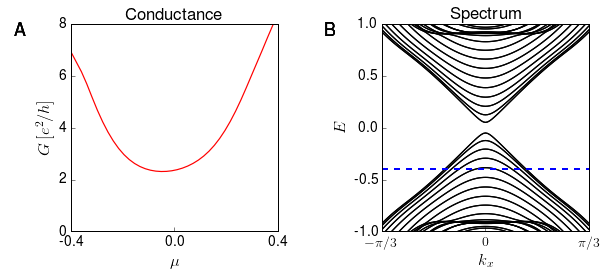
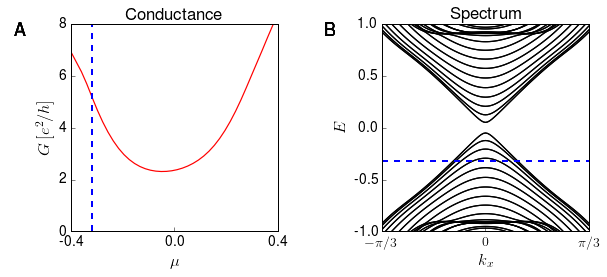
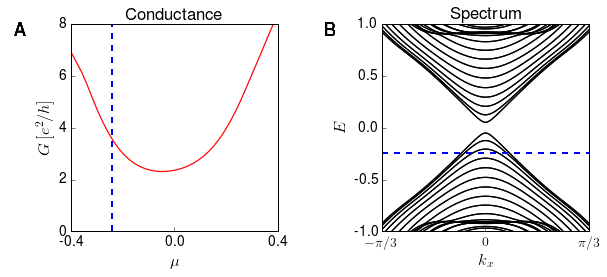
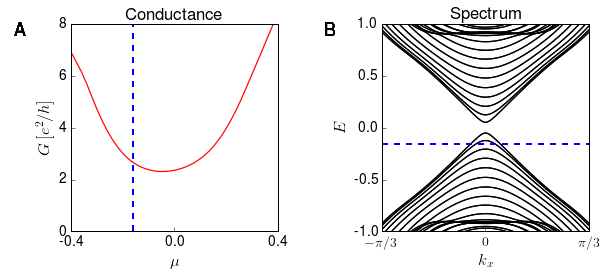
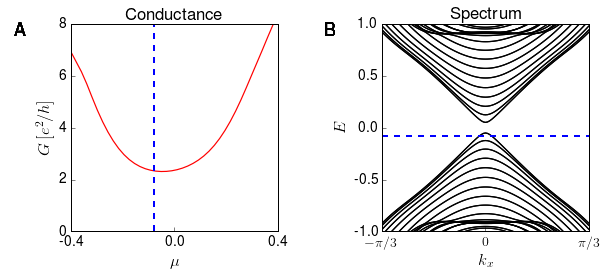
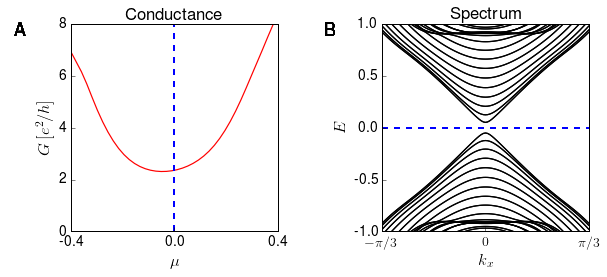
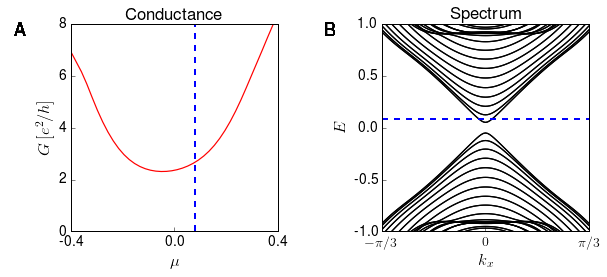
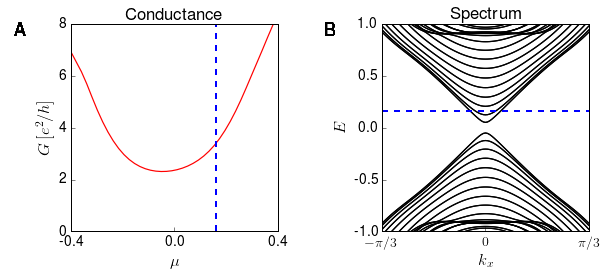
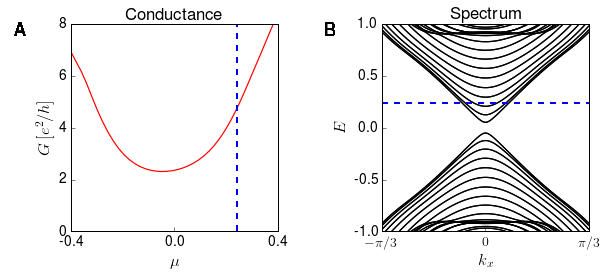
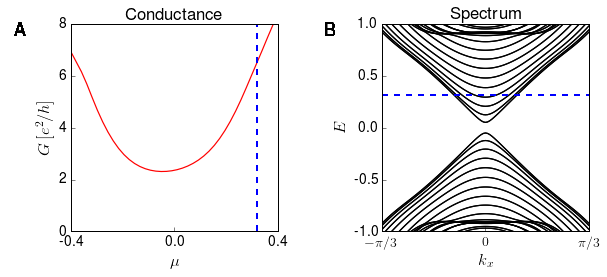
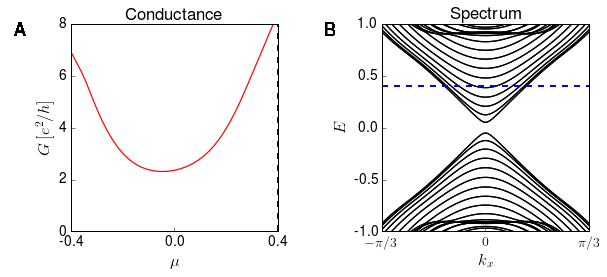

In [3]:
p = SimpleNamespace(A1=1, A2=1, B1=1, B2=1, C=0, D1=0, D2=0, M=-1, Bz=0, mu_scat=0)
L, W, H = 10, 30, 6
cond, mus = cond_mu(p, L, W, H)
cond_plot = plot_cond_mu(cond, mus)
bands_plot = plot_bands(p, L, W, H)
mus = np.linspace(-0.4, 0.4, 11)
holoviews.HoloMap({mu: plot_cond_spect(mu, cond_plot, bands_plot)
                   for mu in mus}, kdims = [r'$\mu$']).collate()

It is also the behavior that is observed experimentally. In the figure below, you see that the resistance of a 3D TI slab reaches a maximum and then decreases as the chemical potential difference between its top and bottom surfaces is varied.

![](figures/zero_field_Rxx.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

Note that in such a measurement, you cannot separate contributions of states coming from the different surfaces, or potentially also from the sides or the sample, or even from the bulk - we'll discuss this issue soon in more detail. 

Nevertheless, the observed maximum in resistance corresponds to the minimum in conductance computed just above, and it demonstrates the presence of a Dirac point between the conduction and valence bands.

This behavior discussed above is not very striking. For instance, the same behavior is observed in graphene. The conductance is not sensitive to degeneracies in the electron spectrum in a qualitative way, so just from it, we cannot demonstrate that the surface of a 3D TI has a single Dirac cone, unlike graphene which has four. Hence, while the measurement above is a signature of a surface state, it is not a particularly striking one. 

Perhaps we will be more lucky with topological signatures of 3D topological insulators, if we look at the Hall conductance?

# Landau levels

In last chapter, we saw that one single surface of a 3D topological insulator is characterized by a Hall conductance of $ (n+1/2)\, e^2/h$. We also pointed out that there are always two surfaces, say the top and bottom one of a slab, which gives a total Hall conductance of $(2n+1)\,e^2/h$ and makes it hard to observe the half-integer Hall conductance.

You may say - OK, we can live with this and be happy with our $(2n+1)$ sequence. After all, it looks almost as unique as the $(n+1/2)$ sequence. Sure, it does not allow us to see directly the half-integer value, but it gives a step between plateaus which is twice the usual one, and no plateau with $n=0$. After all, measuring *twice* that sequence was a good enough probe for graphene.

So let's look at a Hall conductance measurements performed on a slab of a 3D TI, focusing for instance on the blue trace. 

![](figures/LL_spectroscopy.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

You see a sequence of plateaus with integer steps of a normal height $e^2/h$. Nothing special. Why did our prediction of a $(2n+1)$ sequence fail? 

The reason is that there is no symmetry at all between top and bottom surfaces, they are really independent. For instance, they might have different doping, and hence be characterized by different values $n_\textrm{top}$ and $n_\textrm{bottom}$ of the Chern integer.

Therefore, rather than observing a sequence $e^2/h\,(2n+1)$, we observe a more conventional sequence given by $e^2/h\,(n_\textrm{top}+n_\textrm{bottom}+1)$, with the usual $e^2/h$ steps between different plateaus.

So, even by studying the Landau levels experimentally, we do not get a topological signature. But do not despair, luckily there is a much better thing that we can do rather than just measuring conductance: looking at the energy spectrum of the surface states directly.

In [4]:
question = ("Which control parameter can remove the 0th plateau in the QHE measurement? ")

answers = ["Increasing the magnetic field.",
           "Gate voltage difference (which controls difference in electron density) between the surfaces.",
           "Increasing topological mass.",
           "Adding an in-plane magnetic field."]

explanation = ("Gate voltage difference changes the filling of the individual states without shifting the total density of electrons. "
            "This can therefore shift the plateaus of each surface. Magnetic field and topological mass are part of generating the "
               " $0^{th}$ plateau to begin with so cannot eliminate it. ")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=1, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'answers': ['Increasing the magnetic field.', 'Gate voltage difference (which controls difference in electron density) between the surfaces.', 'Increasing topological mass.', 'Adding an in-plane magnetic field.'], 'correct_answer': 1, 'max_attempts': 2, 'question': 'Which control parameter can remove the 0th plateau in the QHE measurement? ', 'explanation': 'Gate voltage difference changes the filling of the individual states without shifting the total density of electrons. This can therefore shift the plateaus of each surface. Magnetic field and topological mass are part of generating the  $0^{th}$ plateau to begin with so cannot eliminate it. '})

# Spectroscopy of the surface of a 3D topological insulator

Amazingly, the surface states of a 3D topological insulator can be directly imaged experimentally using the technique of Angle Resolved Photo Emission Spectroscopy - or, in short, [ARPES](http://en.wikipedia.org/wiki/Angle-resolved_photoemission_spectroscopy).

In ARPES, X-ray photons are shot vertically into a metal surface in order to eject electrons out of it. Due to energy and momentum conservation, the emitted electrons have the same momentum (parallel to the surface) that they had in the crystal, and an energy which is related to their band energy in the crystal. Hence, ARPES is the ideal tool to measure the energy dispersion of the surface states of a solid, i.e. $E(k_x, k_y)$ as a function of momenta $\hbar k_x$ and $\hbar k_y$.

Below, we see an example of ARPES spectra for the surface states of a strong topological insulator Bi$_2$ Se$_3$:

![](figures/arpes_fig1.png)

(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

ARPES can only eject electrons - so only occupied states below the Fermi level are visible in the experiment, but of course one can still map out the Fermi surface at different energies by changing the chemical potential in the crystal. In the ARPES results above we see the results for different dopings of the crystal.

In the top panel of the figure above, we see that by changing the chemical potential, the Fermi surface shrinks from a circle to a point, exactly what you would expect for electrons with a Dirac-like dispersion.

While the top panels shows where the occupied states lie in the $(k_x, k_y)$ plane, in the second and third rows we see a cross-section of the energy as a function of momentum, where the Dirac cone is clearly visible, emerging from a bulk valence band filled with electrons.

In [5]:
question = ("Why do you think ARPES observes surface states even if there is conductance through the bulk?")

answers = ["ARPES can only observe occupied states and therefore bulk conductance is not an issue. ",
           "Since ARPES measures the spectrum in a momentum resolved way, it can separate out surface and bulk states.",
           "ARPES does not measure conductance and therefore bulk electronic states are not an issue.",
        "Since ARPES measures the spectrum in an energy resolved way, it can selectively choose the surface states in the bulk gap."]

explanation = ("The surface states live within the energy gap of the bulk. Since ARPES directly measure $E(k)$, it separates out "
            "surface states from bulk states, which are in different energy ranges. ")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'answers': ['ARPES can only observe occupied states and therefore bulk conductance is not an issue. ', 'Since ARPES measures the spectrum in a momentum resolved way, it can separate out surface and bulk states.', 'ARPES does not measure conductance and therefore bulk electronic states are not an issue.', 'Since ARPES measures the spectrum in an energy resolved way, it can selectively choose the surface states in the bulk gap.'], 'correct_answer': 3, 'max_attempts': 2, 'question': 'Why do you think ARPES observes surface states even if there is conductance through the bulk?', 'explanation': 'The surface states live within the energy gap of the bulk. Since ARPES directly measure $E(k)$, it separates out surface states from bulk states, which are in different energy ranges. '})

# Quasiparticle interference (QPI)

Scanning tunneling microscopy (STM) is another tool to image surface states in a topological insulator. In the process of STM we tunnel electrons into the surface from a metallic tip. In contrast to ARPES, the electrons are not going into free space, so we don't have momentum resolution. On the other hand, we do trade momentum resolution for nearly atomic spatial resolution. We know where exactly on the surface the electron came from.

Tunneling into a uniform surface can tell us a little bit about which orbital on an atom, the electrons at a certain energy come from. Otherwise, we'd see a uniform surface, which wouldn't have much information.  We can make things more interesting and, strangely enough, get more information by sprinkling some impurities on the surface. The impurities scatter the surface electrons and produce a standing wave pattern on the surface, which depends on the Fermi surface momenta of the electrons at the particular tunneling energy (Note: in this unit we refer to the equal energy surface in momentum space at the tunneling energy as Fermi surface for convenience). The resulting pattern is referred to QPI. Specifically, Fourier transforming the QPI pattern directly maps out the momentum transfer across the Fermi-surface of the surface state. 

Clearly, we can expect to map out some properties of the momentum space scattering on the surface of the topological insulator. 

In the simulation below. we see that the Fourier transform shows an interesting pattern: 

![](figures/QPI_pic_adapted.png)
(adapted, copyright Hasan lab, Princeton, see license in the beginning of the chapter)  

By comparing the QPI patterns showing spin-dependent and spin-independent scattering (respectively on the left and right column on the right side of the arrow), we see that the intensity at momenta connecting opposite points on the Fermi surface is suppressed in the case of spin-independent scattering.

In fact, by comparing the fourier transform of the QPI on the right with the Fermi surface on the left, we begin to see that the absence of back-scattering, which is one of the key properties of the topological insulator surface state plays a key role. As you might remember from the quantum spin hall systems - elastic backscattering of electrons is forbidden between states at $\bf k$ and $-\bf k$ because of Kramers' theorem. Looking at the QPI pattern from spin-independent impurities and comparing it with the Fermi surface confirms this. 

# The issue of bulk conductivity

One of the central issues that has plagued the experimental progress with topological insulators is the presence of bulk doping or conductance in most naturally grown crystals. You can see this simply by looking at the ARPES plots below:

![](figures/bulk_conductance_TI.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

What you see is that the Fermi-energy, which is the highest energy till which you can eject electrons in ARPES intersects the conduction band. This means that in the native state the conduction band of the electrons is occupied and the fermi level is not in the gap. In the figure above, the situation is worst for pure Antimony in the extreme left panel, which is really a semimetal with overlapping electron and hole bands. In this case, independent of fermi level position, the system would remain metallic. Moving from pure Sb to $Bi_2 Se_3$ improves this somewhat, but still does not make this an insulator. Theoretically, we do expect pure $Bi_2 Se_3$ to be an insulator - but in reality, the system typically have Se vacancies, which make it metallic.

Being metallic really ruins a lot of interesting properties of the topological insulators. So a lot of effort is going in to fixing it up. Below, we see some of the results from these attempts:

![](figures/insulating_TI.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

where various combinations of $Bi$, $Se$ and $Te$ have been combined to drive the system insulating. By looking at the ARPES spectra, it should look convincing that by varying different conditions, the fermi level is indeed shifting in to the interior of the gap. The experimental tricks used to get this working range between changing the pressure of various elements in the growth condition to counter doping the surface etc.  But the resistance results seem to be improving quite a bit.

# Hexagonal warping

ARPES measurements on the surface of topological materials in the bismuth family also demonstrated an interesting (even though non-topological) feature of the surface states.

The effective Dirac Hamiltonian is linear in momentum and has a full rotational symmetry in the $(x,y)$ plane of the surface, making the Fermi surface circular. However, moving away in energy from the Dirac point, experimentalists observed a different shape of the Fermi surface, similar to a snowflake:

![](figures/warping.png)
(copyright Hasan lab, Princeton, see license in the beginning of the chapter)

It's clear that this shape cannot be explained by the Dirac Hamiltonian with its rotational invariance. In order to take into account this deformation of the Fermi surface, we have to think about the crystal symmetries of the surface. In BiSe and BiTe compounds, there is no full rotational symmetry, but only a lower three-fold rotation symmetry. We can take into account this effect by adding a correction to the effective Dirac Hamiltonian.

This is exactly what was done in this article:

In [6]:
PreprintReference("0908.1418", show_abstract=False)

There Liang Fu made a relatively simple theoretical exercise. He listed all the terms in the Hamiltonian allowed by time-reversal and crystalline symmetries, that are proportional to $k^3.$ This is the result:

$$
H(\mathbf{k}) = E_0(k) + v\, (1+\alpha \mathbf{k}^2)\,(k_x\sigma_y - k_y\sigma_x) + \frac{\lambda}{2}\,(k^3_++k^3_-)\,\sigma_z.
$$

You see a correction to the Dirac velocity proportional to $\alpha \mathbf{k}^2$, which doesn't break the rotational symmetry, as well as the term with $\lambda$, which is responsible for the warping.

Let's plot the spectrum of this extended effective Hamiltonian:

:Overlay
   .Trisurface.I  :Trisurface   [$k_x$,$k_y$]   (E)
   .Trisurface.II :Trisurface   [$k_x$,$k_y$]   (E)
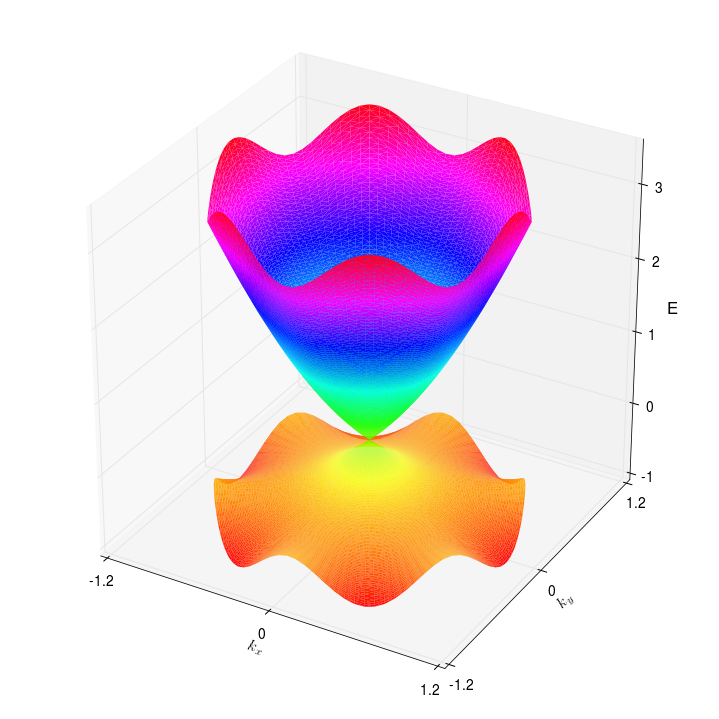

In [7]:
plot_warping()

This Hamiltonian reproduces correctly the *hexagonal warping* of the Fermi surface. In particular, independently of the parameters $\lambda$ and $\alpha$, the vertices of the hexagon are always aligned with the $x$ crystal axis, as is observed experimentally.

In addition to modifying the shape of the Fermi surface, we see that the extra term is proportional to $\sigma_z$, and rotates the spin of the surface state out of plane. This strongly affects the scattering properties of the surface state.

# Outlook: from basic science to potential applications

David Vanderbilt will conclude this week's lectures by offering a perspective on the future of the field.

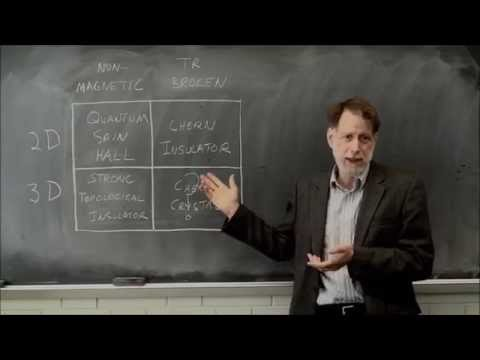

In [8]:
MoocVideo("WZmNeEwM1N4",  src_location="6.2-summary")

In [9]:
MoocDiscussion("Questions", "3DTI materials and signatures")

MoocDiscussion(**{'display_name': '3DTI materials and signatures', 'discussion_category': 'Questions', 'discussion_id': '099ba034a0ba28eaf675262c8749b797', 'discussion_target': '3DTI materials and signatures'})